In [1]:
# import libraries
import torch
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split,KFold
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import LinearRegression
import numpy as np
import torch.nn as nn
from tqdm.auto import trange, tqdm
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


In [2]:
# Load the data
tensile_df =  pd.read_excel("../Tensile_Properties_Data.xlsx", header=0, skiprows=1)
tensile_df

,Reference,Material,Material Group,C (wt.%),Si (wt.%),Mn (wt.%),P (wt.%),S (wt.%),Ni (wt.%),Cr (wt.%),...,Width (mm),Aspect Ratio (L/W),Aspect Ratio (R/W),Aspect Ratio (T/W),Test Temperature (C),Strain Rate (1/s),Yield Strength (MPa),Ultimate Tensile Strength (MPa),Uniform Elongation (%),Total Elongation (%)
0,1,SS304L,"NSM, Rector Internals",0.02,0.45,1.30,NaN,NaN,8.02,18.30,...,1.2,4.166700,1.1667,0.625000,23.0,0.001000,274.0,789.0,67.00,76.00
1,1,SS304L,"NSM, Rector Internals",0.02,0.45,1.30,NaN,NaN,8.02,18.30,...,0.8,4.437500,0.3750,0.500000,23.0,0.001000,272.0,781.0,69.00,80.00
2,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,1.2,4.166700,1.1667,0.416667,23.0,0.001000,710.0,767.0,7.90,14.80
3,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,0.8,3.187500,0.3750,0.500000,23.0,0.001000,607.0,760.0,10.80,23.10
4,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,0.8,3.187500,0.3750,0.500000,23.0,0.001000,725.0,782.0,6.60,18.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,114.0,0.222807,NaN,0.114035,760.0,0.000067,214.0,572.0,59.35,67.66
1469,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,NaN,NaN,NaN,NaN,760.0,0.000067,207.0,494.0,38.80,47.80
1470,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,NaN,NaN,NaN,NaN,760.0,0.003667,101.0,352.0,31.22,47.25
1471,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,25.0,2.032000,NaN,0.000000,760.0,0.000067,177.0,497.0,40.40,46.50


In [3]:
# Check the data information for each column.
tensile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 56 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Reference                        1473 non-null   int64  
 1   Material                         1473 non-null   object 
 2   Material Group                   1473 non-null   object 
 3   C (wt.%)                         1210 non-null   object 
 4   Si (wt.%)                        1174 non-null   float64
 5   Mn (wt.%)                        1179 non-null   float64
 6   P (wt.%)                         1157 non-null   float64
 7   S (wt.%)                         965 non-null    float64
 8   Ni (wt.%)                        1387 non-null   float64
 9   Cr (wt.%)                        1404 non-null   float64
 10  Mo (wt.%)                        1331 non-null   float64
 11  Al (wt.%)                        484 non-null    float64
 12  N (wt.%)            

In [4]:
# Select the composition columns
compostion_cols = tensile_df.columns[3:29]
compostion_cols

Index(['C (wt.%)', 'Si (wt.%)', 'Mn (wt.%)', 'P (wt.%)', 'S (wt.%)',
       'Ni (wt.%)', 'Cr (wt.%)', 'Mo (wt.%)', 'Al (wt.%)', 'N (wt.%)',
       'Ti (wt.%)', 'Fe (wt.%)', 'Nb (wt.%)', 'B (wt.%)', 'Cu (wt.%)',
       'V (wt.%)', 'Mg (wt.%)', 'Y (wt.%)', 'Zr (wt.%)', 'Zn (wt.%)',
       'W (wt.%)', 'Sn (wt.%)', 'Co (wt.%)', 'O (wt.,%)', 'Ta (wt.%)',
       'H (wt.%)'],
      dtype='object')

In [5]:
# Fill the nan values with 0 for the comospition columns
tensile_df[compostion_cols]  = tensile_df[compostion_cols].fillna(0)
tensile_df['Irradiation Dose (mdpa)']  = tensile_df['Irradiation Dose (mdpa)'].fillna(0)
tensile_df['Irradiation Temperature (C)']  = tensile_df['Irradiation Temperature (C)'].fillna(0)

In [6]:
# Displace the latest dataframe information
tensile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 56 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Reference                        1473 non-null   int64  
 1   Material                         1473 non-null   object 
 2   Material Group                   1473 non-null   object 
 3   C (wt.%)                         1473 non-null   object 
 4   Si (wt.%)                        1473 non-null   float64
 5   Mn (wt.%)                        1473 non-null   float64
 6   P (wt.%)                         1473 non-null   float64
 7   S (wt.%)                         1473 non-null   float64
 8   Ni (wt.%)                        1473 non-null   float64
 9   Cr (wt.%)                        1473 non-null   float64
 10  Mo (wt.%)                        1473 non-null   float64
 11  Al (wt.%)                        1473 non-null   float64
 12  N (wt.%)            

In [7]:
# Displace the unique values of the Zr, C and Fe compositions, 
# the initial data collection contains some < signs or ppm, bal, we want to check if these columns have this sign.
print('unique values for Zr (wt.%) column:' + str(tensile_df['Zr (wt.%)'].unique()))
print(100*'_')
print('unique values for C (wt.%) column:' + str(tensile_df['C (wt.%)'].unique()))
print(100*'_')
print('unique values for Fe (wt.%) column:' + str(tensile_df['Fe (wt.%)'].unique()))

unique values for Zr (wt.%) column:[0 98.173 'bal' 1.44]
____________________________________________________________________________________________________
unique values for C (wt.%) column:[0.02 0 0.018 0.01 0.21 0.09 0.055 0.17 0.24 0.07 0.1 0.2 0.14 0.006 0.136
 0.098 0.03 0.18 0.036 '150-400ppm' '<40 ppm' 0.12 0.064 0.061 0.063 0.06
 0.05 0.04 0.058 0.009 0.008 0.014 0.065 0.066 0.053 0.048 0.057 0.039
 0.043 0.041]
____________________________________________________________________________________________________
unique values for Fe (wt.%) column:[71.836 79.41 18.7 0.35 0.2 68.052 57.980000000000004 96.828 90.174
 63.537800000000004 86.78999999999999 97.71 96.978 70.77 96.504 99.13 0
 0.25 86.326 89.53999999999999 67.9 97.1003 94.904 71.089 0.165 '<0.6'
 99.19 64.94000000000001 52.6088 58.8682 66.80699999999999 63.4728 96.843
 67.36000000000001 68.90299999999999 65.57600000000001 64.889 72.245
 70.85600000000001 70.856 67.656 64.6745 66.408 64.62395 66.038 66.252
 65.054 65.15

In [8]:
# Remove the data with <, ppm and bal text in these there columns. 
tensile_df = tensile_df[~tensile_df['Zr (wt.%)'].isin(['<','ppm','bal'])]
tensile_df = tensile_df[~tensile_df['C (wt.%)'].isin(['<','ppm','bal'])]
tensile_df = tensile_df[~tensile_df['Fe (wt.%)'].isin(['<','ppm','bal'])]

In [9]:
# Check the data again, make sure  the data is cleaned
print('unique values for Zr (wt.%) column:' + str(tensile_df['Zr (wt.%)'].unique()))
print(100*'_')
print('unique values for C (wt.%) column:' + str(tensile_df['C (wt.%)'].unique()))
print(100*'_')
print('unique values for Fe (wt.%) column:' + str(tensile_df['Fe (wt.%)'].unique()))

unique values for Zr (wt.%) column:[0 98.173 1.44]
____________________________________________________________________________________________________
unique values for C (wt.%) column:[0.02 0 0.018 0.01 0.21 0.09 0.055 0.17 0.24 0.07 0.1 0.2 0.14 0.006 0.136
 0.098 0.03 0.18 0.036 0.12 0.064 0.061 0.063 0.06 0.05 0.04 0.058 0.009
 0.008 0.014 0.065 0.066 0.053 0.048 0.057 0.039 0.043 0.041]
____________________________________________________________________________________________________
unique values for Fe (wt.%) column:[71.836 79.41 18.7 0.35 0.2 68.052 57.980000000000004 96.828 90.174
 63.537800000000004 86.78999999999999 97.71 96.978 70.77 96.504 99.13 0
 0.25 86.326 89.53999999999999 67.9 97.1003 94.904 71.089 99.19
 64.94000000000001 52.6088 58.8682 66.80699999999999 63.4728 96.843
 67.36000000000001 68.90299999999999 65.57600000000001 64.889 72.245
 70.85600000000001 70.856 67.656 64.6745 66.408 64.62395 66.038 66.252
 65.054 65.1522 65.0159999999999 65.7088 64.6432 64.9213

In [10]:
# convert all of the composition columns' data type to float
tensile_df[compostion_cols]  = tensile_df[compostion_cols].astype(float)

In [11]:
# Select all the sub-sized type ss316  samples.
tensile_df  = tensile_df[(tensile_df['Material Group'].str.contains('ss316', case=False))& (tensile_df['Specimen Size'] == 'Sub-sized')]

In [12]:
# check the data again.
tensile_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 556 entries, 21 to 989
Data columns (total 56 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Reference                        556 non-null    int64  
 1   Material                         556 non-null    object 
 2   Material Group                   556 non-null    object 
 3   C (wt.%)                         556 non-null    float64
 4   Si (wt.%)                        556 non-null    float64
 5   Mn (wt.%)                        556 non-null    float64
 6   P (wt.%)                         556 non-null    float64
 7   S (wt.%)                         556 non-null    float64
 8   Ni (wt.%)                        556 non-null    float64
 9   Cr (wt.%)                        556 non-null    float64
 10  Mo (wt.%)                        556 non-null    float64
 11  Al (wt.%)                        556 non-null    float64
 12  N (wt.%)                  

In [13]:
# Drop the columns that don't have  enough data records.
tensile_df = tensile_df.drop(columns=[ 'Reference','Manufacturing','Cooling', 'Material', 'Treatment','Specimen Size Type',
                                       'Irradiation Time (h)', 'Fillet Radius (mm)', 'Specimen Size',
                                       'Post Treatment Temperature (C)','Post Treatment Time (h)','Microstructure', 'Aspect Ratio (R/W)', 'Yield Strength (MPa)',
                                       'Ultimate Tensile Strength (MPa)', 'Total Elongation (%)','Specimen Shape'
                                       ])


In [14]:
# Dpsplay the latest dataframe information.
tensile_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 556 entries, 21 to 989
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Material Group                556 non-null    object 
 1   C (wt.%)                      556 non-null    float64
 2   Si (wt.%)                     556 non-null    float64
 3   Mn (wt.%)                     556 non-null    float64
 4   P (wt.%)                      556 non-null    float64
 5   S (wt.%)                      556 non-null    float64
 6   Ni (wt.%)                     556 non-null    float64
 7   Cr (wt.%)                     556 non-null    float64
 8   Mo (wt.%)                     556 non-null    float64
 9   Al (wt.%)                     556 non-null    float64
 10  N (wt.%)                      556 non-null    float64
 11  Ti (wt.%)                     556 non-null    float64
 12  Fe (wt.%)                     556 non-null    float64
 13  Nb (wt.%)

In [15]:
# remove nan values from the dataset
tensile_df = tensile_df.dropna()
tensile_df = tensile_df.reset_index(drop=True)
tensile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Material Group                86 non-null     object 
 1   C (wt.%)                      86 non-null     float64
 2   Si (wt.%)                     86 non-null     float64
 3   Mn (wt.%)                     86 non-null     float64
 4   P (wt.%)                      86 non-null     float64
 5   S (wt.%)                      86 non-null     float64
 6   Ni (wt.%)                     86 non-null     float64
 7   Cr (wt.%)                     86 non-null     float64
 8   Mo (wt.%)                     86 non-null     float64
 9   Al (wt.%)                     86 non-null     float64
 10  N (wt.%)                      86 non-null     float64
 11  Ti (wt.%)                     86 non-null     float64
 12  Fe (wt.%)                     86 non-null     float64
 13  Nb (wt.

In [16]:
# sort the dataframe by Ultimate Tensile Strength values.
tensile_df = tensile_df.sort_values(by='Uniform Elongation (%)').reset_index(drop=True)


In [17]:
# Select columns for modeling.

input_features_df =  tensile_df.drop(columns=['Uniform Elongation (%)'])

In [18]:
# Encode the categorical columns
input_features_df['Material Group'] = input_features_df['Material Group'].astype('category')
input_features_df['Material Group'] = input_features_df['Material Group'].cat.codes

input_features_df['Treatment – Three Categories'] = input_features_df['Treatment – Three Categories'].astype('category')
input_features_df['Treatment – Three Categories'] = input_features_df['Treatment – Three Categories'].cat.codes

In [19]:
# make sure all the input data is float data type.
input_features_df = input_features_df.astype('float')

In [20]:
# define the input features and input targets values.
features = input_features_df
targets = tensile_df['Uniform Elongation (%)']

Run # 1 Fold # 1
Pearson CC: 0.9913369434668889
R2 score: 0.9810512634862177
RMSE: 2.3763392259020586
MAE: 1.6705802330678468


c:\Users\LZ\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\core.py:160: UserWarning: [21:48:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


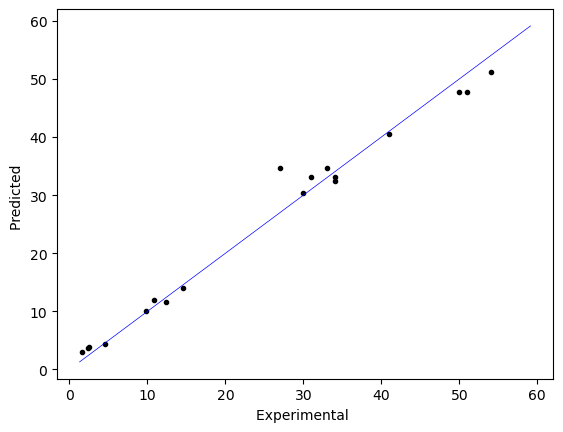

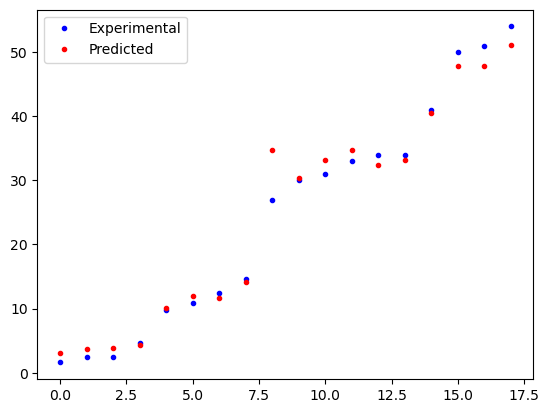

Run # 1 Fold # 2
Pearson CC: 0.9841863687855914
R2 score: 0.9665147539869614
RMSE: 4.105371169362039
MAE: 2.7432696918279382


c:\Users\LZ\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\core.py:160: UserWarning: [21:48:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


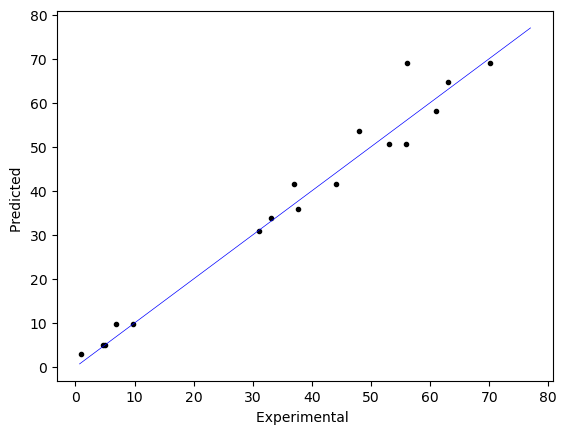

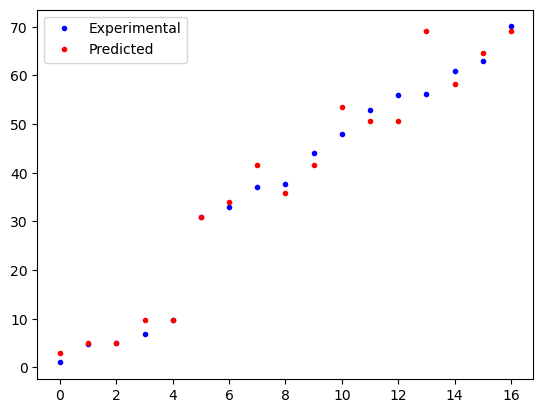

c:\Users\LZ\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\core.py:160: UserWarning: [21:48:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


Run # 1 Fold # 3
Pearson CC: 0.9356986410557474
R2 score: 0.8457529687675902
RMSE: 8.460019882473256
MAE: 3.478926101241953


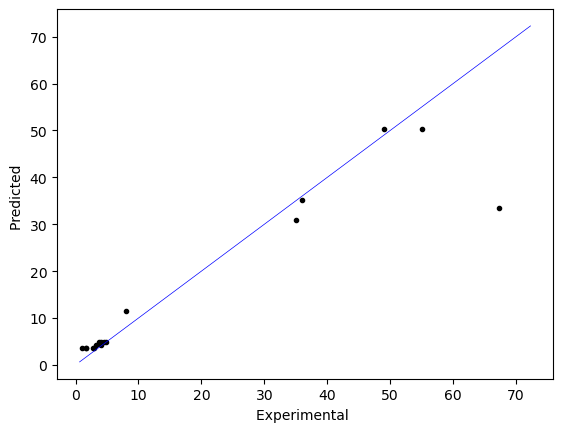

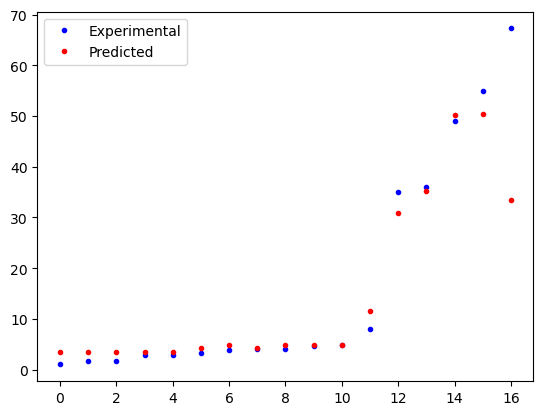

Run # 1 Fold # 4


c:\Users\LZ\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\core.py:160: UserWarning: [21:48:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


Pearson CC: 0.9896464178161227
R2 score: 0.9723163216228036
RMSE: 2.850989337971095
MAE: 2.075367988012946


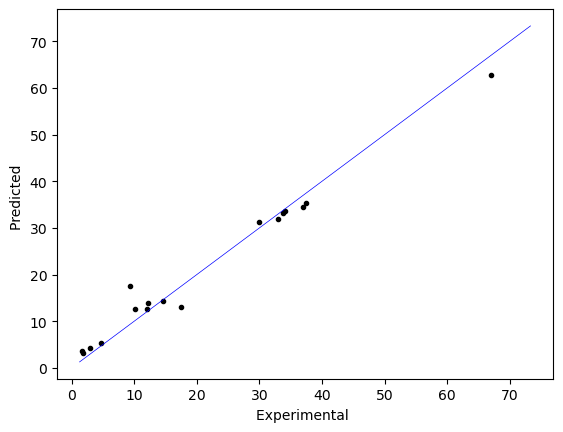

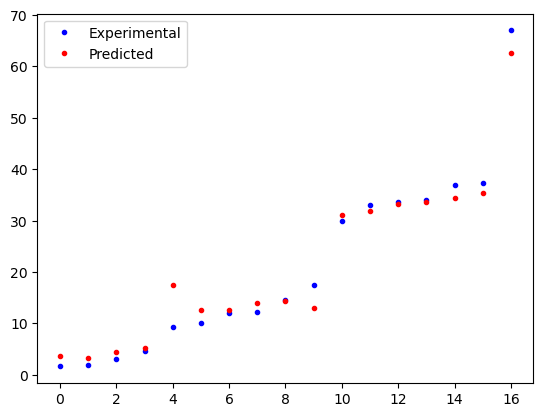

c:\Users\LZ\anaconda3\envs\tf-gpu\lib\site-packages\xgboost\core.py:160: UserWarning: [21:48:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


Run # 1 Fold # 5
Pearson CC: 0.9874946682114703
R2 score: 0.9505628570107785
RMSE: 4.713456272772435
MAE: 3.260046871771611


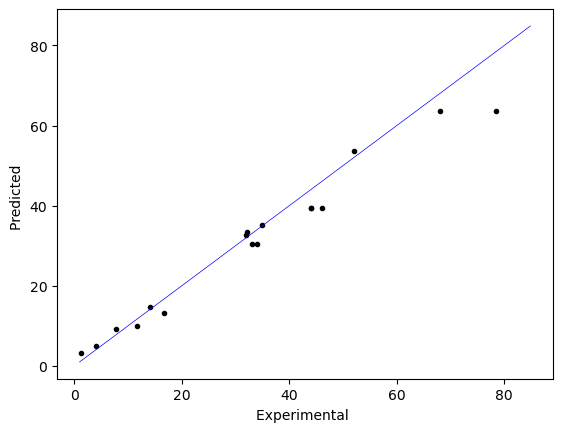

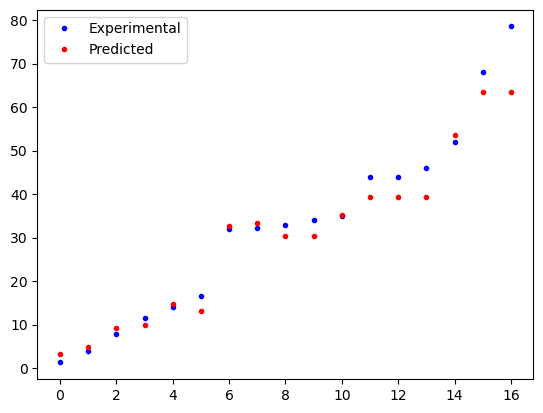

In [21]:
# XGBoost Model
import xgboost as xg


nruns = 1
nfolds = 5

PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
MSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            scale = StandardScaler()
            x_train = scale.fit_transform(x_train)
            x_test = scale.transform(x_test)

            # Initialize LightGBM Regressor
            xgboost_regressor = xg.XGBRegressor(objective ='reg:linear',
                            n_estimators = 10, seed = 123)

            # Train the model
            xgboost_regressor.fit(x_train, y_train)

            # Make predictions on the testing set
            y_pred = xgboost_regressor.predict(x_test)

            # Evaluation
            R2_score[j, i] = r2_score(y_test, y_pred)
            PearsonCC[j, i] =  pearsonr(y_test, np.squeeze(y_pred))[0]
            MSE[j, i] = np.sqrt(mean_squared_error(y_test, y_pred))
            MAE[j, i] = mean_absolute_error(y_test, y_pred)

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {MSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')


            # Parity plot, actual versus predicted values
            plt.plot(y_test, y_pred, 'k.')
            bounds = (min(y_test.min(), y_pred.min()) - 0.1*y_pred.min(), max(y_test.max(), y_pred.max())+ 0.1 * y_pred.max())
            plt.plot([bounds[0], bounds[1]], [bounds[0], bounds[1]],'b-', linewidth=0.5, label="Parity Line") # identity line
            plt.xlabel("Experimental ", fontsize=10)
            plt.ylabel("Predicted ", fontsize=10)
            plt.show()

            plt.plot(np.array(y_test), 'b.', label='Experimental')
            plt.plot(np.array(y_pred), 'r.', label='Predicted')
            plt.legend()
            plt.show()

In [22]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'MSE': MSE.flatten(),
                    'MAE': MAE.flatten()},index=None)
df1

,Pearson CC,R2 Score,MSE,MAE
0,0.991337,0.981051,2.376339,1.670580
1,0.984186,0.966515,4.105371,2.743270
2,0.935699,0.845753,8.460020,3.478926
3,0.989646,0.972316,2.850989,2.075368
4,0.987495,0.950563,4.713456,3.260047


In [23]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
MSE_mean = np.mean(MSE)
MAE_mean = np.mean(MAE)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
MSE_std = np.std(MSE)
MAE_std = np.std(MAE)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'MSE Mean': MSE_mean, 'MSE Std': MSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std },index=[0])

df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,MSE Mean,MSE Std,MAE Mean,MAE Std
0,0.977673,0.021123,0.94324,0.049748,4.501235,2.149987,2.645638,0.686636


Run # 1 Fold # 1
Pearson CC: 0.9816931716503264
R2 score: 0.9618848694203016
RMSE: 3.3702880030396454
MAE: 1.9292862520000744


c:\Users\LZ\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\gaussian_process\kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


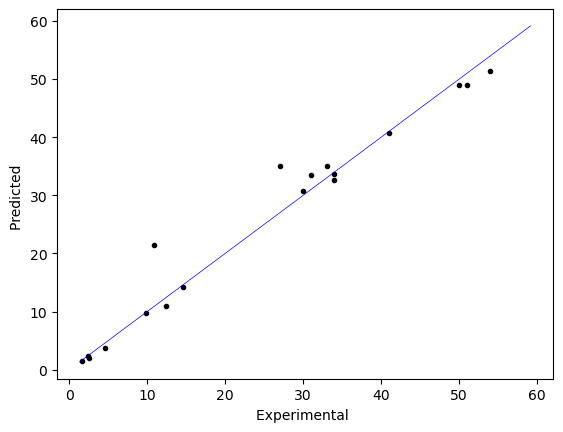

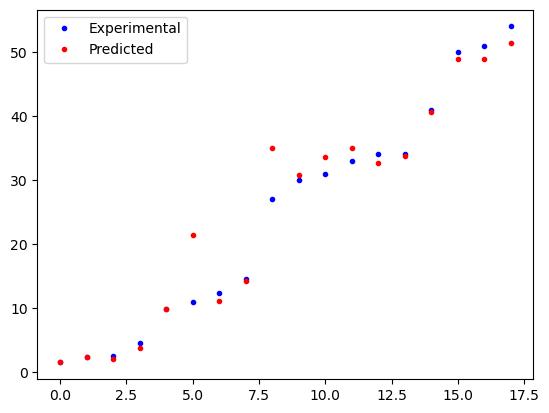

Run # 1 Fold # 2
Pearson CC: 0.9772514725223481
R2 score: 0.9536839009928253
RMSE: 4.82827133144781
MAE: 3.507431683189136


c:\Users\LZ\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\gaussian_process\kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


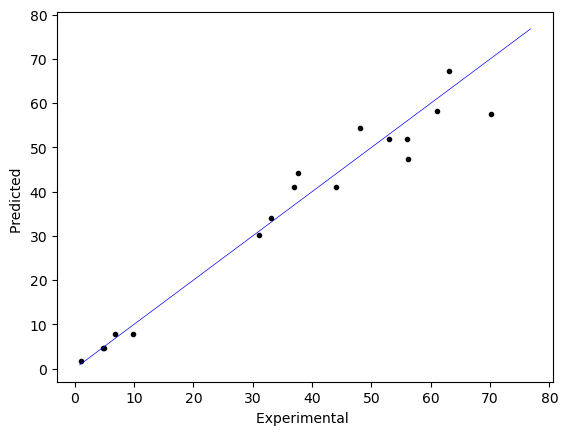

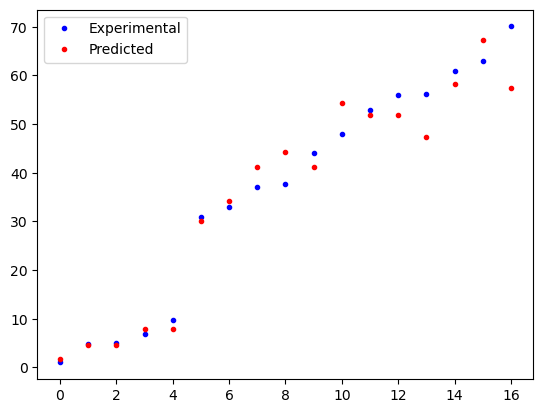

Run # 1 Fold # 3
Pearson CC: 0.9390301013732657
R2 score: 0.8528268268671821
RMSE: 8.263752537225475
MAE: 3.0903496468929816


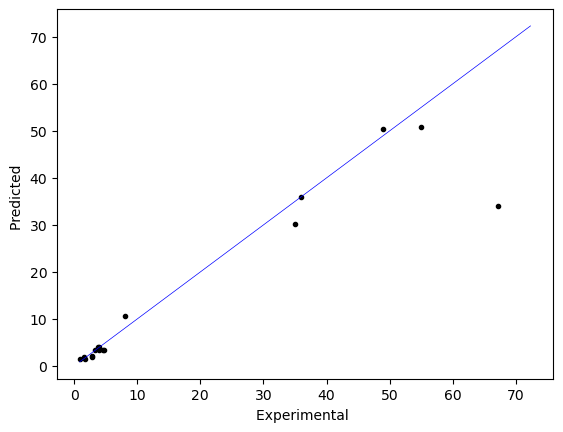

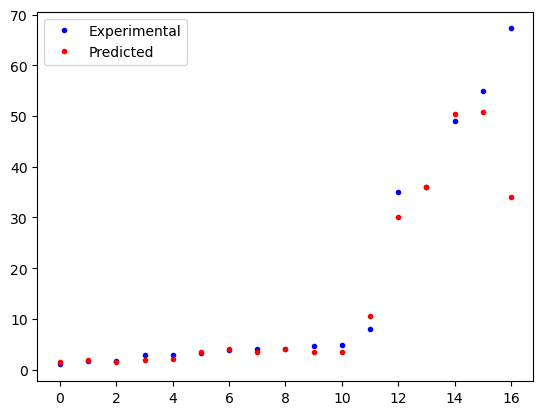

Run # 1 Fold # 4
Pearson CC: 0.9496875505439122
R2 score: 0.8609185053675457
RMSE: 6.390257668990212
MAE: 3.7992843895526494


c:\Users\LZ\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\gaussian_process\kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


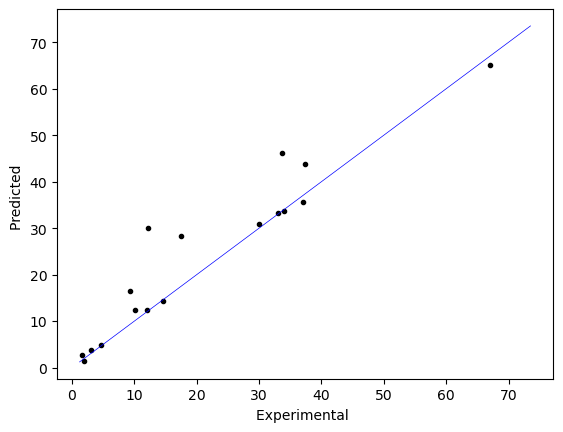

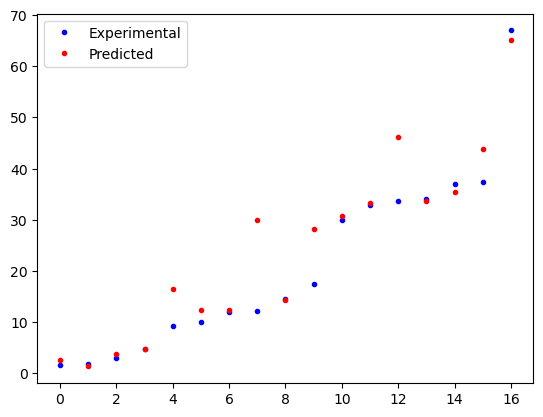

Run # 1 Fold # 5
Pearson CC: 0.9640790302103674
R2 score: 0.9132415329575161
RMSE: 6.244083973288463
MAE: 4.118907453820164


c:\Users\LZ\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\gaussian_process\kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\LZ\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\gaussian_process\kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


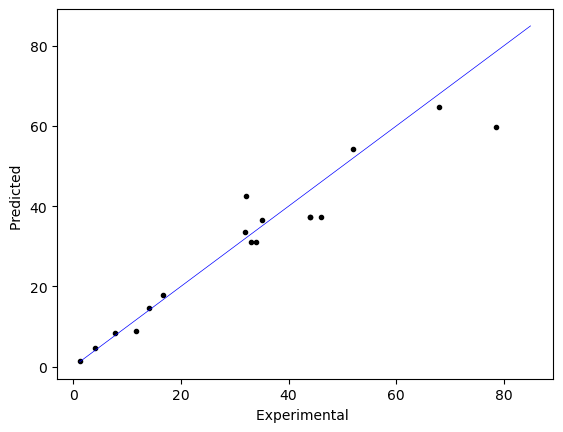

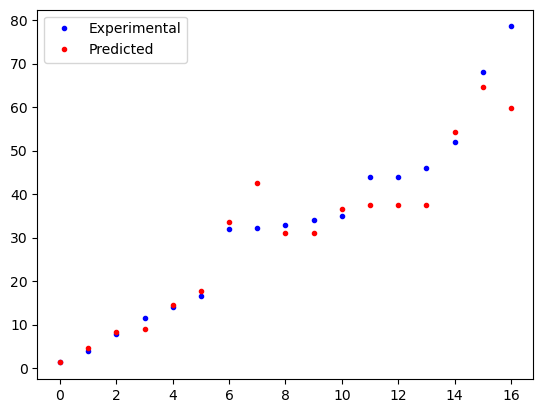

In [24]:
# Gaussian Process Regression Model
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, DotProduct, ConstantKernel as C


nruns = 1
nfolds = 5

PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
MSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)
        kernel = C(1.0) * Matern(length_scale=1.0) + WhiteKernel(noise_level=1.0) + C(1.0) * DotProduct(sigma_0=1.0)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            scale = StandardScaler()
            x_train = scale.fit_transform(x_train)
            x_test = scale.transform(x_test)

            # Initialize GP Regressor


            model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, normalize_y=True)

            model.fit(x_train, y_train)

            mu_z, std_z = model.predict(x_test, return_std=True)
            y_pred_test = mu_z
            y_pred_unc_test = std_z

            # Evaluation
            R2_score[j, i] = r2_score(y_test, y_pred_test)
            PearsonCC[j, i] =  pearsonr(y_test, np.squeeze(y_pred_test))[0]
            MSE[j, i] = np.sqrt(mean_squared_error(y_test, y_pred_test))
            MAE[j, i] = mean_absolute_error(y_test, y_pred_test)

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {MSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')


            # Parity plot, actual versus predicted values
            plt.plot(y_test, y_pred_test, 'k.')
            bounds = (min(y_test.min(), y_pred_test.min()) - 0.1*y_pred_test.min(), max(y_test.max(), y_pred_test.max())+ 0.1 * y_pred_test.max())
            plt.plot([bounds[0], bounds[1]], [bounds[0], bounds[1]],'b-', linewidth=0.5, label="Parity Line") # identity line
            plt.xlabel("Experimental ", fontsize=10)
            plt.ylabel("Predicted ", fontsize=10)
            plt.show()

            plt.plot(np.array(y_test), 'b.', label='Experimental')
            plt.plot(np.array(y_pred_test), 'r.', label='Predicted')
            plt.legend()
            plt.show()

In [25]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'MSE': MSE.flatten(),
                    'MAE': MAE.flatten()},index=None)
df1

,Pearson CC,R2 Score,MSE,MAE
0,0.981693,0.961885,3.370288,1.929286
1,0.977251,0.953684,4.828271,3.507432
2,0.939030,0.852827,8.263753,3.090350
3,0.949688,0.860919,6.390258,3.799284
4,0.964079,0.913242,6.244084,4.118907


In [26]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
MSE_mean = np.mean(MSE)
MAE_mean = np.mean(MAE)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
MSE_std = np.std(MSE)
MAE_std = np.std(MAE)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'MSE Mean': MSE_mean, 'MSE Std': MSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std },index=[0])

df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,MSE Mean,MSE Std,MAE Mean,MAE Std
0,0.962348,0.016145,0.908511,0.045338,5.819331,1.640828,3.289052,0.759623


Run # 1 Fold # 1
Pearson CC: 0.9908207924322415
R2 score: 0.9815976737314328
RMSE: 2.341826260079127
MAE: 1.4844876010798536


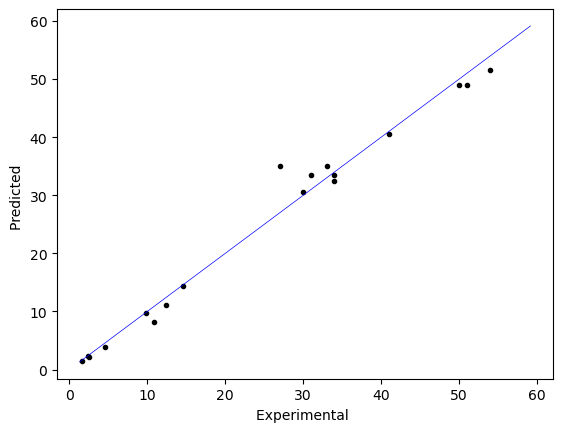

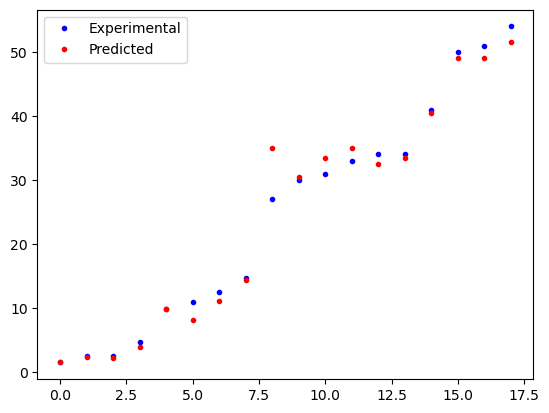

Run # 1 Fold # 2
Pearson CC: 0.9770527117052734
R2 score: 0.9152552836590909
RMSE: 6.531034775851305
MAE: 3.9064244433437523


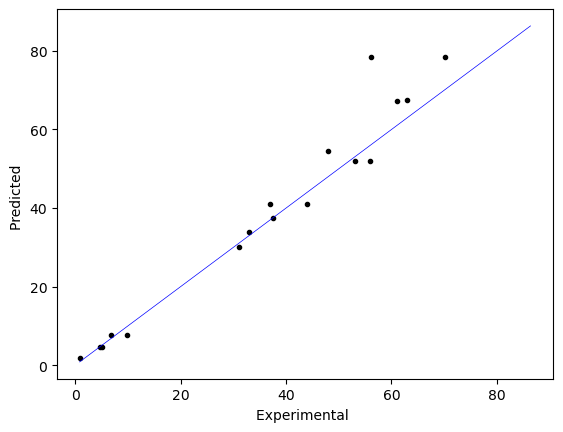

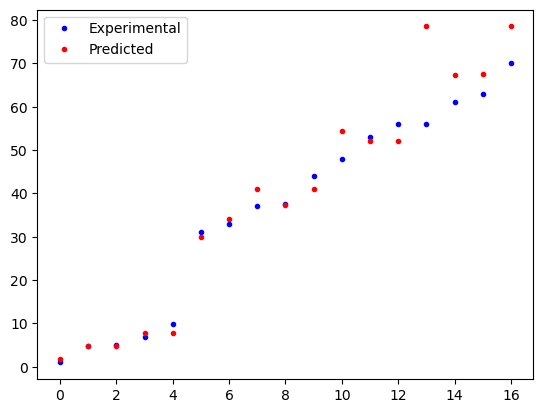

Run # 1 Fold # 3
Pearson CC: 0.9932474807117931
R2 score: 0.9772018752906132
RMSE: 3.252464306653407
MAE: 1.8380305909069938


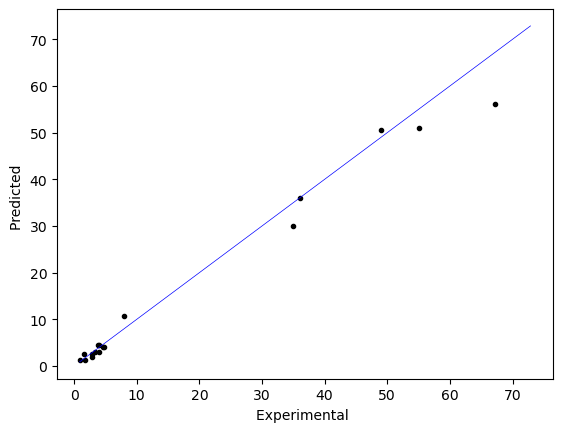

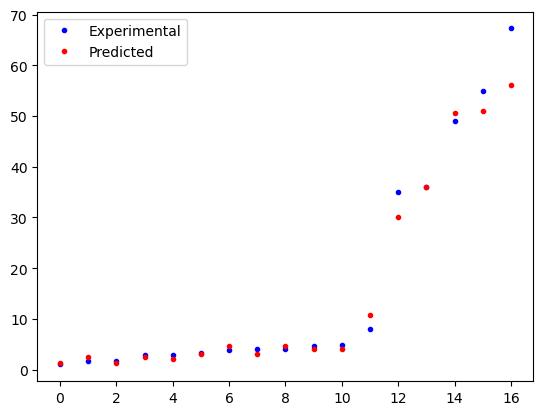

Run # 1 Fold # 4
Pearson CC: 0.9915053895062328
R2 score: 0.9823949380492727
RMSE: 2.2735393455756125
MAE: 1.4669714773241669


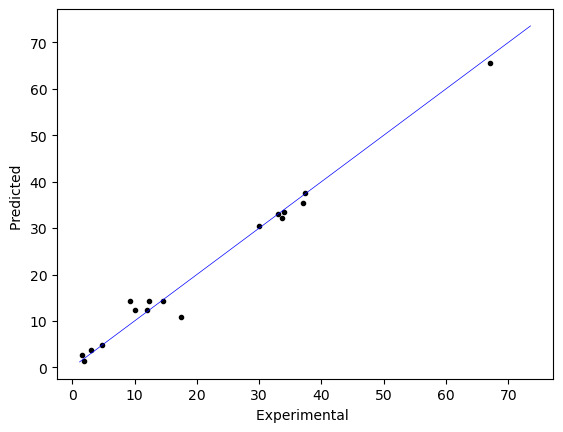

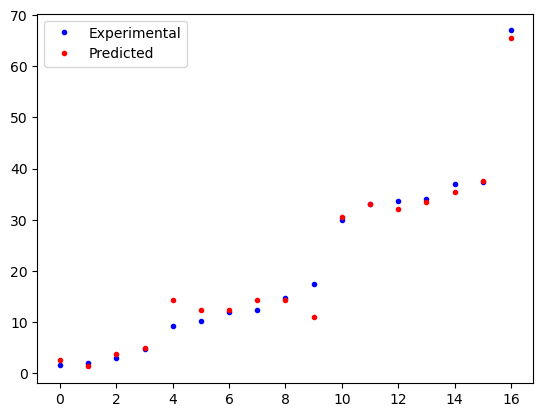

Run # 1 Fold # 5
Pearson CC: 0.9919091016818734
R2 score: 0.9757552765066323
RMSE: 3.300816775823268
MAE: 2.6178664288037767


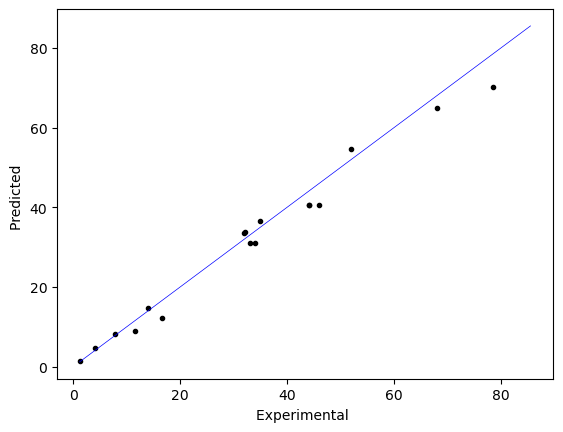

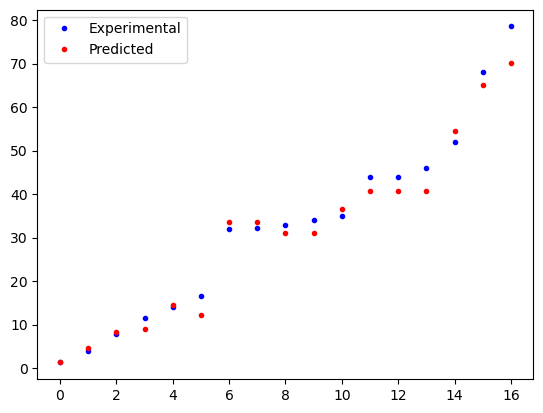

In [27]:
# Decision Tree model
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error


nruns = 1
nfolds = 5

PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
MSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            scale = StandardScaler()
            x_train = scale.fit_transform(x_train)
            x_test = scale.transform(x_test)

            # Initialize the Decision Tree Regressor
            regressor = DecisionTreeRegressor()

            # Train the model
            regressor.fit(x_train, y_train)

            # Make predictions on the testing set
            y_pred = regressor.predict(x_test)

            # Evaluation
            R2_score[j, i] = r2_score(y_test, y_pred)
            PearsonCC[j, i] =  pearsonr(y_test, np.squeeze(y_pred))[0]
            MSE[j, i] = np.sqrt(mean_squared_error(y_test, y_pred))
            MAE[j, i] = mean_absolute_error(y_test, y_pred)

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {MSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')


            # Parity plot, actual versus predicted values
            plt.plot(y_test, y_pred, 'k.')
            bounds = (min(y_test.min(), y_pred.min()) - 0.1*y_pred.min(), max(y_test.max(), y_pred.max())+ 0.1 * y_pred.max())
            plt.plot([bounds[0], bounds[1]], [bounds[0], bounds[1]],'b-', linewidth=0.5, label="Parity Line") # identity line
            plt.xlabel("Experimental ", fontsize=10)
            plt.ylabel("Predicted ", fontsize=10)
            plt.show()

            plt.plot(np.array(y_test), 'b.', label='Experimental')
            plt.plot(np.array(y_pred), 'r.', label='Predicted')
            plt.legend()
            plt.show()



In [28]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'MSE': MSE.flatten(),
                    'MAE': MAE.flatten()},index=None)
df1

,Pearson CC,R2 Score,MSE,MAE
0,0.990821,0.981598,2.341826,1.484488
1,0.977053,0.915255,6.531035,3.906424
2,0.993247,0.977202,3.252464,1.838031
3,0.991505,0.982395,2.273539,1.466971
4,0.991909,0.975755,3.300817,2.617866


In [29]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
MSE_mean = np.mean(MSE)
MAE_mean = np.mean(MAE)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
MSE_std = np.std(MSE)
MAE_std = np.std(MAE)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'MSE Mean': MSE_mean, 'MSE Std': MSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std },index=[0])

df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,MSE Mean,MSE Std,MAE Mean,MAE Std
0,0.988907,0.00598,0.966441,0.025717,3.539936,1.557287,2.262756,0.921642


Run # 1 Fold # 1
Pearson CC: 0.9406655189595122
R2 score: 0.8819966611874849
RMSE: 5.9301469614643505
MAE: 5.0442704730831


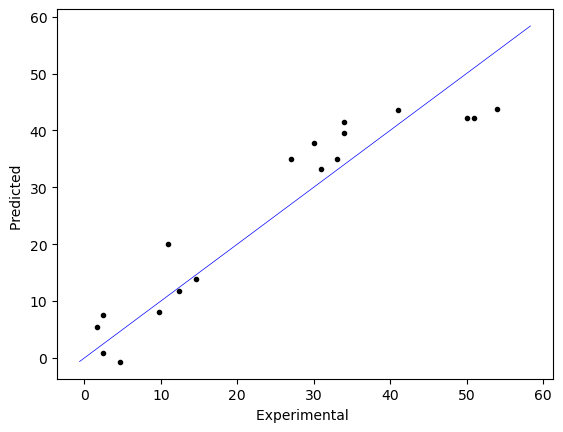

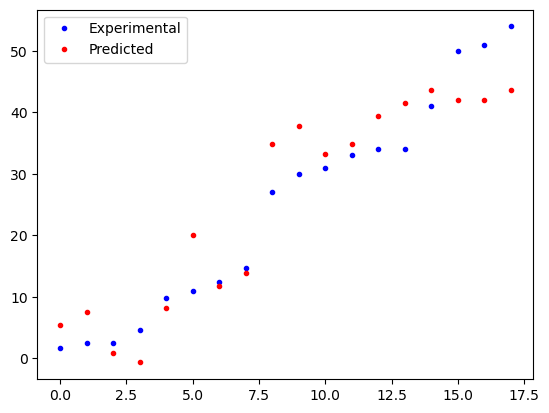

Run # 1 Fold # 2
Pearson CC: 0.9462762168942107
R2 score: 0.792527722342077
RMSE: 10.218936922724163
MAE: 7.958479885734164


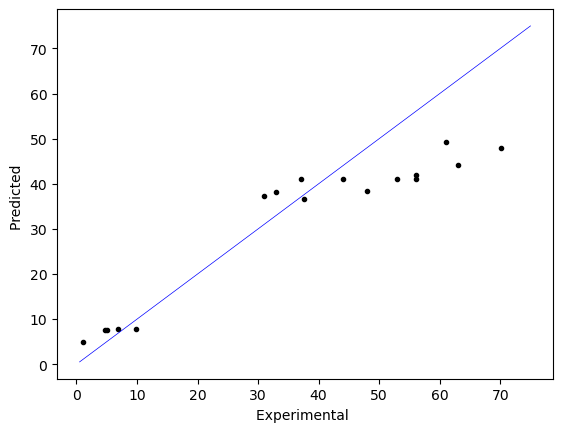

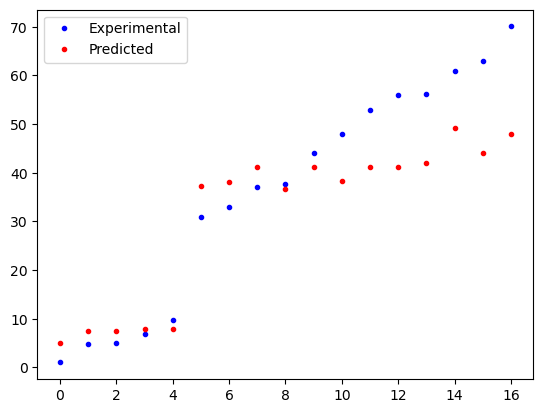

Run # 1 Fold # 3
Pearson CC: 0.9239361901555723
R2 score: 0.7819345690804516
RMSE: 10.059036608439326
MAE: 6.597038460073348


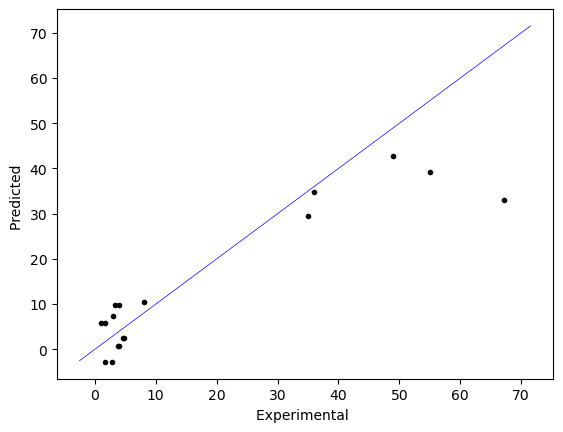

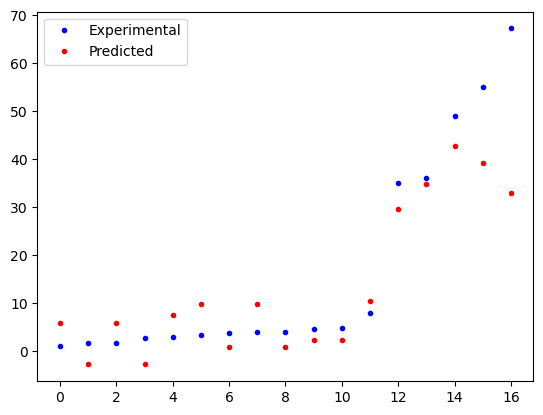

Run # 1 Fold # 4
Pearson CC: 0.9090677147696118
R2 score: 0.7808008654780723
RMSE: 8.02237784949988
MAE: 5.8819805866063515


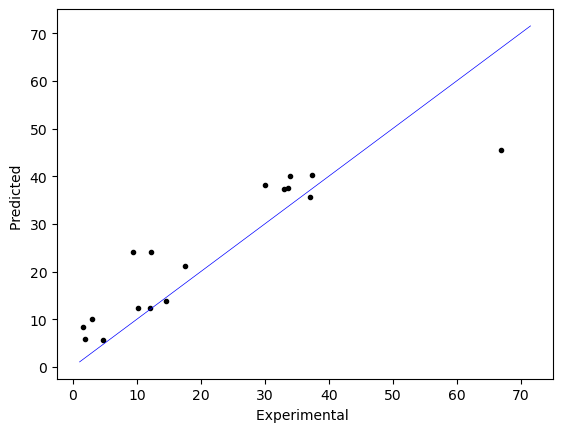

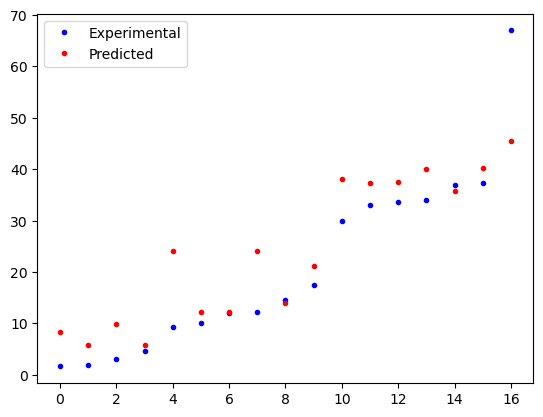

Run # 1 Fold # 5
Pearson CC: 0.9416716160411236
R2 score: 0.7881022717267062
RMSE: 9.758340107455263
MAE: 6.42419071022126


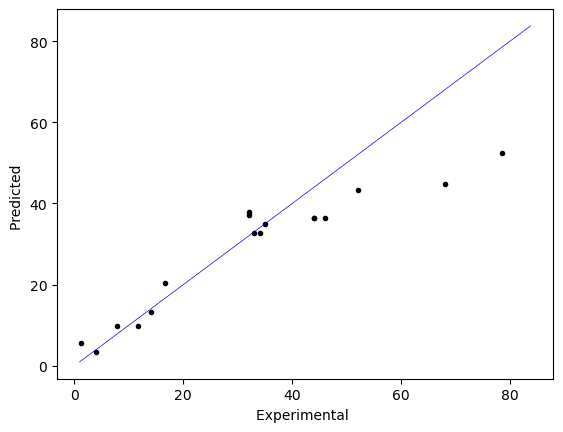

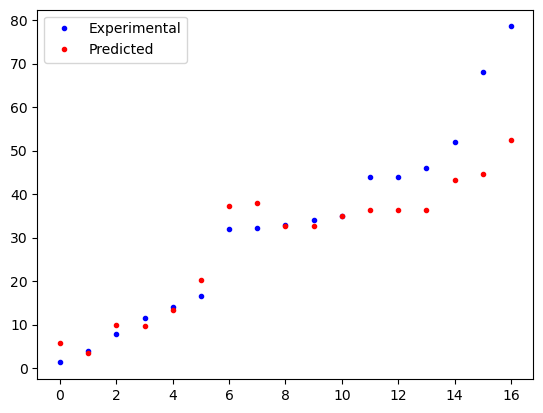

In [30]:
# SVM

from sklearn.svm import SVR

nruns = 1
nfolds = 5

PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
MSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            scale = StandardScaler()
            x_train = scale.fit_transform(x_train)
            x_test = scale.transform(x_test)

            svm_regressor = SVR(kernel='linear')

            svm_regressor.fit(x_train, y_train)

            y_pred = svm_regressor.predict(x_test)

            # Evaluation
            R2_score[j, i] = r2_score(y_test, y_pred)
            PearsonCC[j, i] =  pearsonr(y_test, np.squeeze(y_pred))[0]
            MSE[j, i] = np.sqrt(mean_squared_error(y_test, y_pred))
            MAE[j, i] = mean_absolute_error(y_test, y_pred)

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {MSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')


            # Parity plot, actual versus predicted values
            plt.plot(y_test, y_pred, 'k.')
            bounds = (min(y_test.min(), y_pred.min()) - 0.1*y_pred.min(), max(y_test.max(), y_pred.max())+ 0.1 * y_pred.max())
            plt.plot([bounds[0], bounds[1]], [bounds[0], bounds[1]],'b-', linewidth=0.5, label="Parity Line") # identity line
            plt.xlabel("Experimental ", fontsize=10)
            plt.ylabel("Predicted ", fontsize=10)
            plt.show()

            plt.plot(np.array(y_test), 'b.', label='Experimental')
            plt.plot(np.array(y_pred), 'r.', label='Predicted')
            plt.legend()
            plt.show()



In [31]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'MSE': MSE.flatten(),
                    'MAE': MAE.flatten()},index=None)
df1

,Pearson CC,R2 Score,MSE,MAE
0,0.940666,0.881997,5.930147,5.044270
1,0.946276,0.792528,10.218937,7.958480
2,0.923936,0.781935,10.059037,6.597038
3,0.909068,0.780801,8.022378,5.881981
4,0.941672,0.788102,9.758340,6.424191


In [32]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
MSE_mean = np.mean(MSE)
MAE_mean = np.mean(MAE)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
MSE_std = np.std(MSE)
MAE_std = np.std(MAE)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'MSE Mean': MSE_mean, 'MSE Std': MSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std },index=[0])

df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,MSE Mean,MSE Std,MAE Mean,MAE Std
0,0.932323,0.013877,0.805072,0.038697,8.797768,1.634485,6.381192,0.956331


Run # 1 Fold # 1
Pearson CC: 0.9928184113607883
R2 score: 0.9842235290355129
RMSE: 2.168319321374396
MAE: 1.2023826836261189


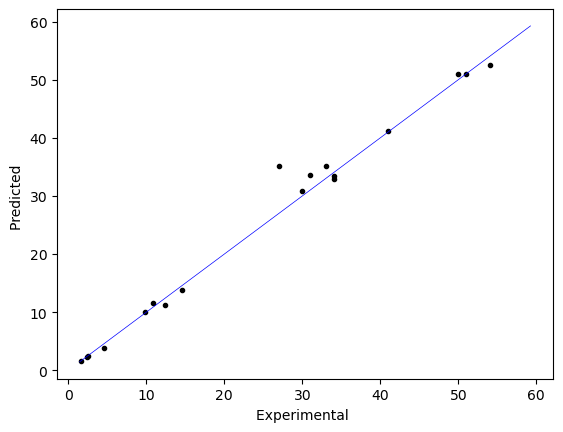

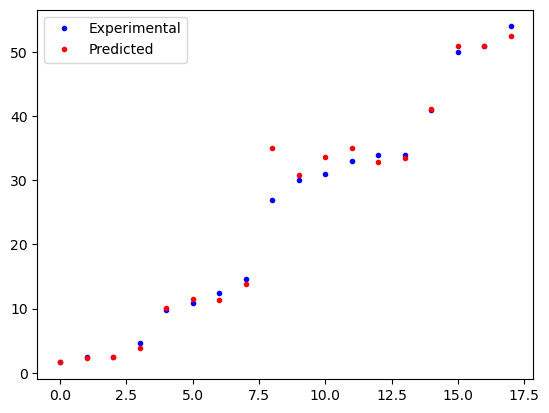

Run # 1 Fold # 2
Pearson CC: 0.9828580887528144
R2 score: 0.9590655702172879
RMSE: 4.539103165806566
MAE: 3.2046730194693187


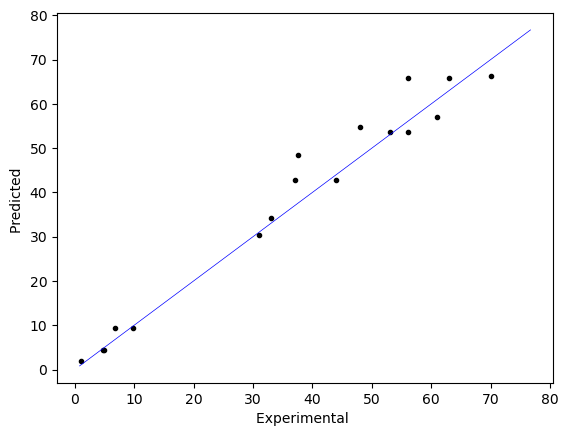

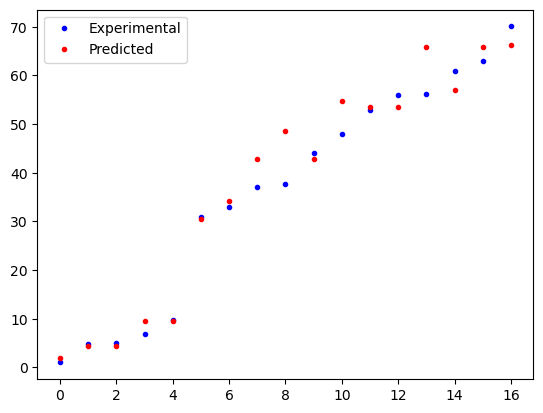

Run # 1 Fold # 3
Pearson CC: 0.9745867822309653
R2 score: 0.9315133058055134
RMSE: 5.63723420618189
MAE: 2.5188887640771966


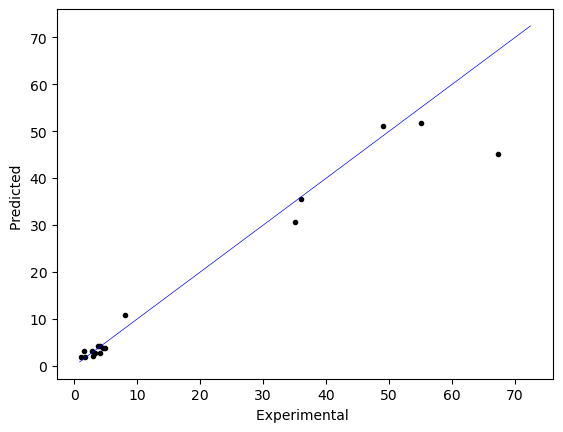

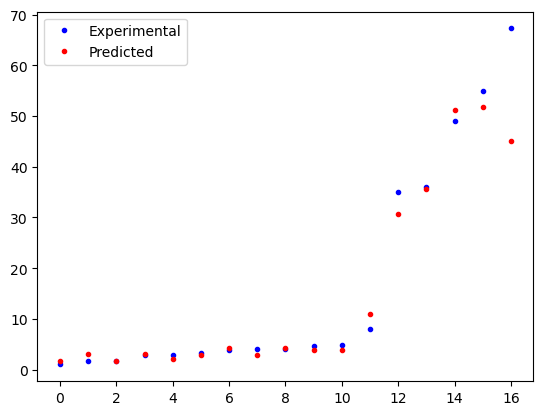

Run # 1 Fold # 4
Pearson CC: 0.9847047675519698
R2 score: 0.9675516775328188
RMSE: 3.0865962219944856
MAE: 2.116144006760654


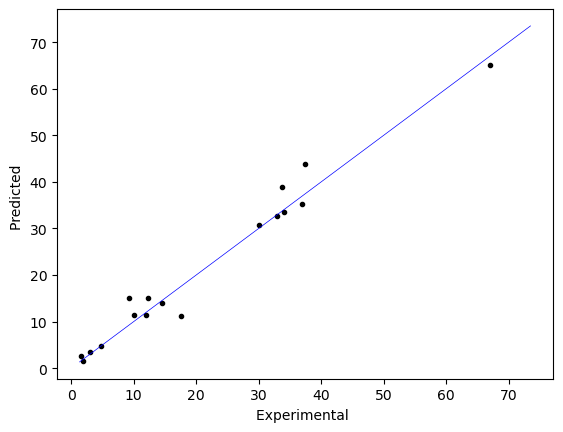

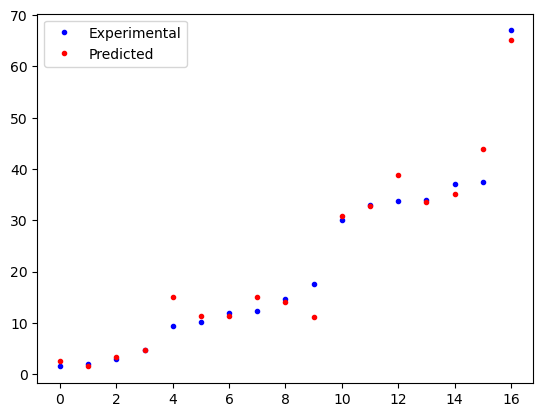

Run # 1 Fold # 5
Pearson CC: 0.9860342780314891
R2 score: 0.9591515512508642
RMSE: 4.284504313536955
MAE: 3.191622577433905


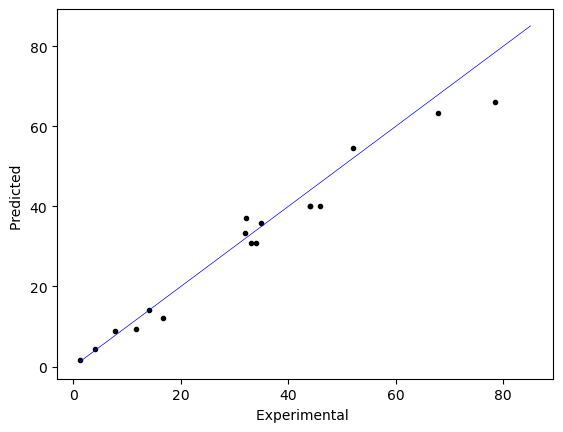

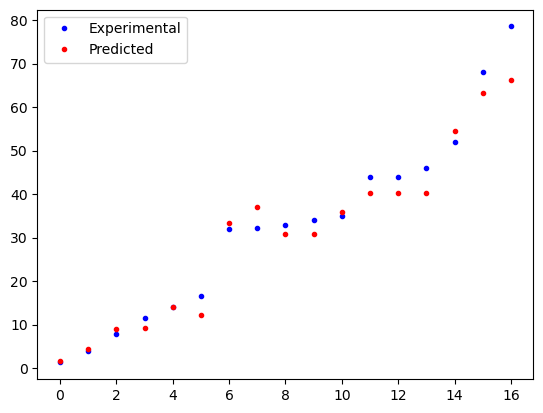

In [33]:
# Random Forest Model
from sklearn.ensemble import RandomForestRegressor

nruns = 1
nfolds = 5

PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
MSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            scale = StandardScaler()
            x_train = scale.fit_transform(x_train)
            x_test = scale.transform(x_test)

            # Initialize Random Forest Regressor
            rf_regressor = RandomForestRegressor(n_estimators=10000, random_state=123)
            # Train the model
            rf_regressor.fit(x_train, y_train)

            # Make predictions on the testing set
            y_pred = rf_regressor.predict(x_test)

            # Evaluation
            R2_score[j, i] = r2_score(y_test, y_pred)
            PearsonCC[j, i] =  pearsonr(y_test, np.squeeze(y_pred))[0]
            MSE[j, i] = np.sqrt(mean_squared_error(y_test, y_pred))
            MAE[j, i] = mean_absolute_error(y_test, y_pred)

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {MSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')


            # Parity plot, actual versus predicted values
            plt.plot(y_test, y_pred, 'k.')
            bounds = (min(y_test.min(), y_pred.min()) - 0.1*y_pred.min(), max(y_test.max(), y_pred.max())+ 0.1 * y_pred.max())
            plt.plot([bounds[0], bounds[1]], [bounds[0], bounds[1]],'b-', linewidth=0.5, label="Parity Line") # identity line
            plt.xlabel("Experimental ", fontsize=10)
            plt.ylabel("Predicted ", fontsize=10)
            plt.show()

            plt.plot(np.array(y_test), 'b.', label='Experimental')
            plt.plot(np.array(y_pred), 'r.', label='Predicted')
            plt.legend()
            plt.show()


In [34]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'MSE': MSE.flatten(),
                    'MAE': MAE.flatten()},index=None)
df1

,Pearson CC,R2 Score,MSE,MAE
0,0.992818,0.984224,2.168319,1.202383
1,0.982858,0.959066,4.539103,3.204673
2,0.974587,0.931513,5.637234,2.518889
3,0.984705,0.967552,3.086596,2.116144
4,0.986034,0.959152,4.284504,3.191623


In [35]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
MSE_mean = np.mean(MSE)
MAE_mean = np.mean(MAE)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
MSE_std = np.std(MSE)
MAE_std = np.std(MAE)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'MSE Mean': MSE_mean, 'MSE Std': MSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std },index=[0])

df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,MSE Mean,MSE Std,MAE Mean,MAE Std
0,0.9842,0.005867,0.960301,0.017067,3.943151,1.202108,2.446742,0.747293


In [36]:
from sklearn.neighbors import KNeighborsRegressor

nruns = 1
nfolds = 5

PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
MSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)
for n in range (1,11):
    print('k-neighbor:'+ str(n) )
    for j in range(nruns):

            kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

            for i, (tr, ts) in enumerate(kf.split(targets)):

                # Display the run number
                print('Run #', j+1, "Fold #", i+1)

                x_train, x_test = features.iloc[tr], features.iloc[ts]
                y_train, y_test = targets[tr], targets[ts]

                scale = StandardScaler()
                x_train = scale.fit_transform(x_train)
                x_test = scale.transform(x_test)



                # Initialize KNeighborsRegressor
                knn_regressor = KNeighborsRegressor(n_neighbors=n)  # You can adjust the number of neighbors (k)

                # Train the model
                knn_regressor.fit(x_train, y_train)

                # Make predictions on the testing set
                y_pred = knn_regressor.predict(x_test)

                # Evaluation
                R2_score[j, i] = r2_score(y_test, y_pred)
                PearsonCC[j, i] =  pearsonr(y_test, np.squeeze(y_pred))[0]
                MSE[j, i] = np.sqrt(mean_squared_error(y_test, y_pred))
                MAE[j, i] = mean_absolute_error(y_test, y_pred)

                print(f'Pearson CC: {PearsonCC[j, i]}')
                print(f'R2 score: {R2_score[j, i]}')
                print(f'RMSE: {MSE[j, i]}')
                print(f'MAE: {MAE[j, i]}')


        # # Data frame
    df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'MSE': MSE.flatten(),
                        'MAE': MAE.flatten()},index=None)
        # Calculate mean values and standard deviations of the scores
    PearsonCC_mean = np.mean(PearsonCC)
    R2_score_mean = np.mean(R2_score)
    MSE_mean = np.mean(MSE)
    MAE_mean = np.mean(MAE)

    PearsonCC_std = np.std(PearsonCC)
    R2_score_std = np.std(R2_score)
    MSE_std = np.std(MSE)
    MAE_std = np.std(MAE)

    # Data frame
    df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                    'MSE Mean': MSE_mean, 'MSE Std': MSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std },index=[0])

    print(df2)



k-neighbor:1
Run # 1 Fold # 1
Pearson CC: 0.94377398874562
R2 score: 0.8891955178557636
RMSE: 5.746414809180897
MAE: 3.166146500523494
Run # 1 Fold # 2
Pearson CC: 0.6781741222348847
R2 score: 0.31400014054880887
RMSE: 18.581796281390112
MAE: 10.424374877418055
Run # 1 Fold # 3
Pearson CC: 0.9403572491145453
R2 score: 0.8414606745008318
RMSE: 8.576922380119802
MAE: 3.5095323157367764
Run # 1 Fold # 4
Pearson CC: 0.6876942582890233
R2 score: -0.38386367154192347
RMSE: 20.15720673093299
MAE: 10.617517687134383
Run # 1 Fold # 5
Pearson CC: 0.813484138063885
R2 score: 0.6382567241467799
RMSE: 12.75008363926602
MAE: 6.842851420506724
   Pearson CC Mean  Pearson CC Std  R2 Score Mean  R2 Score Std   MSE Mean  \
0         0.812697        0.115932        0.45981      0.467957  13.162485   

    MSE Std  MAE Mean   MAE Std  
0  5.558608  6.912085  3.214984  
k-neighbor:2
Run # 1 Fold # 1
Pearson CC: 0.8475891680787635
R2 score: 0.7066583506678624
RMSE: 9.349861403795996
MAE: 4.199687016615948
R

In [37]:
# Define MyDataset object to feed the input data to the model.
class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.features = data
        self.labels = targets

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]

        return feature, label

In [38]:
# NN model
# Evaluate multiple runs of the NN model
nruns = 1
nfolds = 4

# Metrics for performance evaluation
PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)
upper_coverage = np.zeros_like(PearsonCC)
lower_coverage = np.zeros_like(PearsonCC)
mean_interval_width = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            # normalized features to the [0,1] range
            scaler = StandardScaler()
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)

            x_train = x_train.astype(dtype=np.float32)
            x_test = x_test.astype(np.float32)
            y_train_np = y_train.to_numpy(dtype=np.float32)
            y_test_np =  y_test.to_numpy(dtype=np.float32)

            x_train = torch.from_numpy(x_train)
            y_train = torch.from_numpy(y_train_np)

            x_test = torch.from_numpy(x_test)
            y_test = torch.from_numpy(y_test_np)

            train_dataset = MyDataset(x_train, y_train)
            train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8)

            # define DNN
            class MLP(nn.Module):
                  def __init__(self, input_dim=38, output_dim=1, hidden_dim=10, n_hidden_layers=1, use_dropout=False):
                        super().__init__()

                        self.use_dropout = use_dropout
                        if use_dropout:
                              self.dropout = nn.Dropout(p=0.25)
                        self.activation = nn.ReLU()

                        # dynamically define architecture
                        self.layer_sizes = [input_dim] + n_hidden_layers * [hidden_dim] + [output_dim]
                        layer_list = [nn.Linear(self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                                    range(1, len(self.layer_sizes))]
                        self.layers = nn.ModuleList(layer_list)

                  def forward(self, input):
                        hidden = self.activation(self.layers[0](input))
                        for layer in self.layers[1:-1]:
                              hidden_temp = self.activation(layer(hidden))

                              if self.use_dropout:
                                    hidden_temp = self.dropout(hidden_temp)

                              hidden = hidden_temp + hidden  # residual connection

                        output_mean = self.layers[-1](hidden).squeeze()
                        return output_mean

            def train(net, train_dataloader):
                  optimizer = torch.optim.Adam(params=net.parameters(), lr=0.01)
                  criterion = nn.MSELoss()

                  progress_bar = trange(3000)
                  for _ in progress_bar:
                        for i, data in enumerate(train_dataloader):
                              traning_data, training_label = data
                              optimizer.zero_grad()
                              y_pred = net(torch.Tensor(traning_data))
                              loss = criterion(y_pred.squeeze(), torch.Tensor(training_label))
                              progress_bar.set_postfix(loss=f'{loss / features.shape[0]:.3f}')
                              loss.backward()
                              optimizer.step()
                  return net

            # training
            net = MLP(hidden_dim=1000, n_hidden_layers=2)

            train(net, train_dataloader)

            print("Run # ", j+1, "Fold #", i+1)

            # inference
            y_pred = np.array(net(torch.Tensor(x_test)).clone().detach().numpy())

            ## Metrics for evaluating the predictive accuracy of the model
            PearsonCC[j, i] = pearsonr(np.squeeze(y_test), np.squeeze(y_pred))[0]
            R2_score[j, i] = r2_score(y_test, y_pred)
            RMSE[j, i] = np.sqrt(mean_squared_error(y_pred, y_test))
            MAE[j, i] = np.mean(abs(y_pred-np.array(y_test)))

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')

  0%|          | 0/3000 [00:00<?, ?it/s]

Run #  1 Fold # 1
Pearson CC: 0.982671311189423
R2 score: 0.9586748389095459
RMSE: 3.8408708572387695
MAE: 2.7184126377105713


  0%|          | 0/3000 [00:00<?, ?it/s]

Run #  1 Fold # 2
Pearson CC: 0.9930988233406091
R2 score: 0.9862189907220954
RMSE: 2.683621644973755
MAE: 1.9314932823181152


  0%|          | 0/3000 [00:00<?, ?it/s]

c:\Users\LZ\anaconda3\envs\tf-gpu\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Run #  1 Fold # 3
Pearson CC: 0.8809913825017963
R2 score: 0.7206314525351636
RMSE: 8.701939582824707
MAE: 3.5006496906280518


  0%|          | 0/3000 [00:00<?, ?it/s]

c:\Users\LZ\anaconda3\envs\tf-gpu\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Run #  1 Fold # 4
Pearson CC: 0.9671736121033735
R2 score: 0.9086747093053215
RMSE: 6.52221155166626
MAE: 4.313232421875


In [39]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten(), 'Coverage': test_coverage.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE,Coverage
0,0.982671,0.958675,3.840871,2.718413,0.0
1,0.993099,0.986219,2.683622,1.931493,0.0
2,0.880991,0.720631,8.701940,3.500650,0.0
3,0.967174,0.908675,6.522212,4.313232,0.0


In [40]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)


PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)


# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std
0,0.955984,0.044269,0.89355,0.103632,5.437161,2.343408,3.115947,0.886348
